# Start From Here

In [49]:
from mahotas.features import surf
from sklearn.neighbors import NearestNeighbors
import cv2
from matplotlib import pyplot as plt
import numpy as np
from numpy.linalg import norm
from skimage.transform import resize
import glob, os
from tqdm.notebook import tqdm
from sklearn.cluster import KMeans

In [50]:
def find_surf(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = resize(img, (320, 240))
    spoints = surf.surf(img, descriptor_only=True, nr_octaves=4, nr_scales=5, initial_step_size=1, threshold=1e-8, max_points=1024)
    descrs = spoints
    return descrs

In [51]:
limit = 1000
list_files = []
bins_list = []
features_list = []

for file in tqdm(glob.glob(str(os.getcwd())+"\images\*")):
    features = find_surf(cv2.imread(file))
    if len(features)>0:
        for feature in features:
            features_list.append(feature)
        list_files.append(file)
        bins_list.append(features)
        if len(bins_list) == limit:
            break

bins_list = np.array(bins_list)



In [52]:
n_clusters = 100

kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(features_list)

In [53]:
feature_vocab = kmeans.cluster_centers_
num_words = feature_vocab.shape[0]

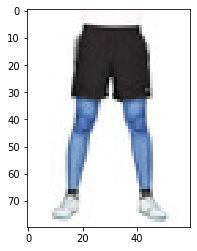

In [54]:
query_img = cv2.imread('images/2106.jpg')
plt.imshow(query_img)
descrs = find_surf(query_img)

In [55]:
from sklearn.neighbors import KDTree

def closest_word_vocab(descrs,feature_vocab):
    tree = KDTree(feature_vocab,leaf_size=1000)                       
    dist, ind = tree.query(descrs, k=1)
    return tree, ind

tree_vocab, indexes = closest_word_vocab(descrs,feature_vocab)

In [102]:
list_hist = np.zeros((limit, n_clusters))

for i in range (limit):
        descrs = bins_list[i]
        dist, ind = tree_vocab.query(descrs, k=1)
        hist = np.zeros(num_words)
        unique_words, count_words = np.unique(ind, return_counts=True)
        hist[unique_words] = count_words
        list_hist[i,:] = hist
        
idf = np.sum(list_hist > 0, axis=0)
idf = np.log(limit / idf)

list_hist = list_hist * idf
list_hist = np.sqrt(list_hist)
list_hist = (list_hist.T / np.linalg.norm(list_hist, axis = 1)).T

In [119]:
query_hist = np.zeros(num_words)
unique_words, count_words = np.unique(indexes, return_counts=True)
query_hist[unique_words] = count_words

In [120]:
# process histogram
query_hist = query_hist * idf
query_hist = np.sqrt(query_hist)
query_hist = query_hist/np.linalg.norm(query_hist)

In [121]:
scores = np.zeros((1,limit))

def matching_score(scores, limit, bins_list,query_hist):
    for i in range (limit):
        scores[0,i]=np.dot(query_hist, list_hist[i])
    return scores
scores=matching_score(scores, limit, bins_list, query_hist)

In [122]:
# sort in descending order
scores_sorted_idx = np.argsort(-scores)
scores_sorted = scores.ravel()[scores_sorted_idx]

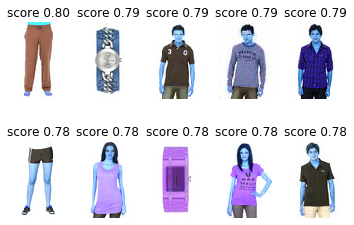

In [60]:
# plot top matches
N=10
top_N_idx = scores_sorted_idx.ravel()[:N]

plt.figure()
for i in range(N):
    
    file = list_files[top_N_idx[i]]    
    img = cv2.imread(file)
    # choose subplot
    plt.subplot(int(np.ceil(N/5)),5,i+1)
    # plot
    plt.imshow(img)
    plt.axis('off')
    plt.title('score %1.2f' % scores_sorted.ravel()[i])